In [ ]:
from DRL.constraints_code.parser import parse_constraints_file
from DRL.constraints_code.feature_orderings import set_ordering
from DRL.constraints_code.compute_sets_of_constraints import compute_sets_of_constraints
import torch
import pandas as pd
import torch.nn as nn
from DRL.constraints_code.correct_predictions import correct_preds, check_all_constraints_sat
import torch.nn.functional as F
import random
import numpy as np
from sklearn.model_selection import train_test_split
import torch.optim as optim

def seed_everything(seed: int):
    """Seed Python, NumPy, and PyTorch for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"All random seeds set to {seed}")


# Simple MLP Generator
class Generator(nn.Module):
    def __init__(self, input_dim=16, output_dim=32, hidden_dim=64):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, z):
        return self.model(z)

def sample(ordering_list, sets_of_constr, n=10000, batch_size=256, epochs=10):
    input_length = 20
    output_length = 10
    
    generator = Generator(input_dim=input_length, output_dim=output_length)
    optimizer = optim.Adam(generator.parameters(), lr=0.001)
    
    noise = torch.rand(size=(n, input_length)).float() * 5
    diversity_weight = 0
    for epoch in range(epochs):
        perm = torch.randperm(n)
        epoch_mae = 0.0
        num_batches = 0
        
        for i in range(0, n, batch_size):
            optimizer.zero_grad()
            
            batch_idx = perm[i:i+batch_size]
            noise_batch = noise[batch_idx]
            
            generated_data = generator(noise_batch)
            generated_data = torch.sigmoid(generated_data)
            
            target = correct_preds(generated_data, ordering_list, sets_of_constr)
            target = torch.tensor(target, dtype=generated_data.dtype)
            
            batch_mean = generated_data.mean(dim=0, keepdim=True)
            diversity_loss = 1.0 / ( ((generated_data - batch_mean) ** 2).mean() + 1e-6 )

            loss_f1 = F.l1_loss(generated_data, target)
            print("loss_f1", loss_f1)
            print("diversity_loss", diversity_loss)
            loss = loss_f1 + diversity_weight * diversity_loss

            loss.backward()
            optimizer.step()
            
            epoch_mae += loss.item()
            num_batches += 1
        
        print(f"Epoch {epoch+1}, MAE: {epoch_mae/num_batches:.6f}")
    
    # Generate final sampled data
    with torch.no_grad():
        generated_data = generator(noise)
        generated_data = torch.sigmoid(generated_data)
        sampled_data = correct_preds(generated_data, ordering_list, sets_of_constr)
    
    return noise, sampled_data


In [ ]:


seed = 42
constraint_path = "/Users/mihajlobulesnij/Documents/system/RAI/project/DRL_DGM/constraints_generated/smt_constraints/n10_r3.1999999999999993_i0.txt"
save_path = "/"

seed_everything(seed)

label_ordering = "predefined"


constraints_file = constraint_path
ordering, constraints = parse_constraints_file(constraints_file)
sets_of_constr = compute_sets_of_constraints(ordering, constraints, verbose=True)
noise, sampled_data = sample(ordering, sets_of_constr)
print(sampled_data[:3] - 0.5)
check_all_constraints_sat(sampled_data, constraints=constraints, error_raise=True)

noise_np = noise.numpy()
predictions_np = sampled_data.numpy()

dataset_np = np.hstack([noise_np, predictions_np])

input_cols = [f"noise_{i}" for i in range(noise_np.shape[1])]
output_cols = [f"pred_{i}" for i in range(predictions_np.shape[1])]
columns = input_cols + output_cols

df = pd.DataFrame(dataset_np, columns=columns)

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=seed)

df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=seed)

base_path = constraint_path.split("/")[-1][:-4] + f"_{seed}"

df_train.to_csv(f"{save_path}/{base_path}_train.csv", index=False)
df_valid.to_csv(f"{save_path}/{base_path}_valid.csv", index=False)
df_test.to_csv(f"{save_path}/{base_path}_test.csv", index=False)


In [8]:
import pandas as pd

In [9]:
df = pd.read_csv("/Users/mihajlobulesnij/Documents/system/RAI/project/DRL_DGM/model_results/input_output_1.csv")
df[["c", "r", "b", "data_seed"]] = df["experiment_path"].str.split("_", expand=True)


In [10]:
data_info = pd.read_csv("/Users/mihajlobulesnij/Documents/system/RAI/project/DRL_DGM/constrains_input_output_1/dataset_info.csv")

In [11]:
info_grouped = data_info.groupby("r").total_combined.mean().reset_index()

In [12]:
df1_grouped = df.groupby("r").model_1_violation.mean().reset_index()
df2_grouped = df.groupby("r").model_2_violation.mean().reset_index()

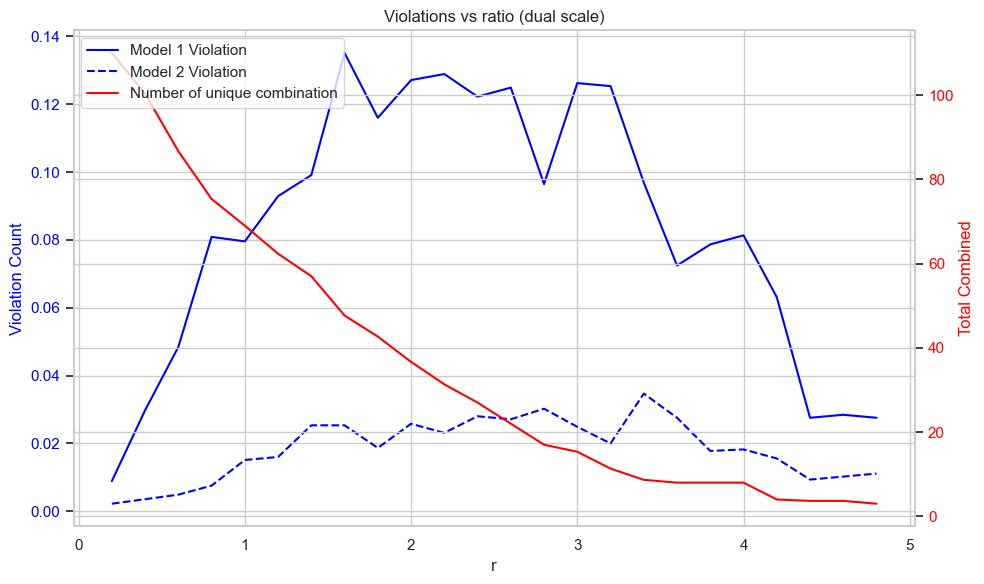

In [13]:
import matplotlib.pyplot as plt

df1_sorted = df1_grouped.sort_values("r")
df1_sorted["r"] = df1_sorted["r"].astype(float)

df2_sorted = df2_grouped.sort_values("r")
df2_sorted["r"] = df2_sorted["r"].astype(float)

info_sorted = info_grouped.sort_values("r")

fig, ax1 = plt.subplots(figsize=(10, 6))

# ---- Left axis: Model violations ----
ax1.plot(
    df1_sorted.r,
    df1_sorted.model_1_violation,
    color='blue',
    linestyle='solid',
    label="Model 1 Violation"
)

ax1.plot(
    df2_sorted.r,
    df2_sorted.model_2_violation,
    color='blue',
    linestyle='dashed',   # <-- MAKE MODEL 2 DASHED
    label="Model 2 Violation"
)

ax1.set_xlabel("r")
ax1.set_ylabel("Violation Count", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# ---- Right axis: Total Combined ----
ax2 = ax1.twinx()
ax2.plot(
    info_sorted.r,
    info_sorted.total_combined,
    color='red',
    label="Number of unique combination"
)
ax2.set_ylabel("Total Combined", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# ---- Merged legend ----
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Violations vs ratio (dual scale)")
plt.tight_layout()
plt.show()


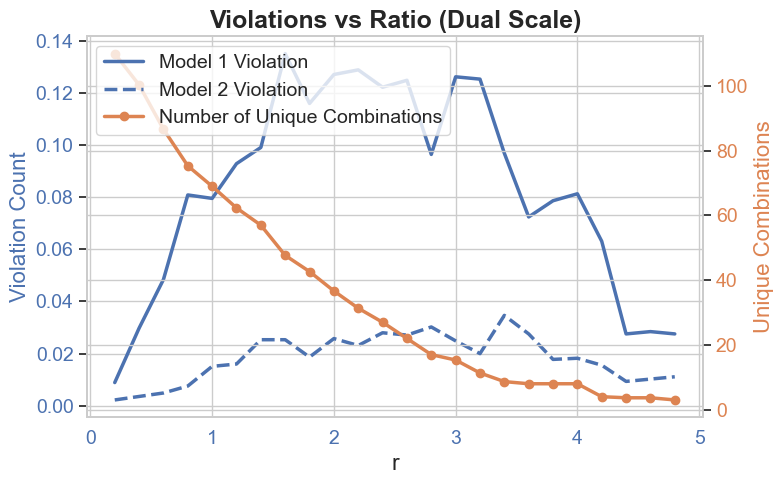

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

df1_sorted = df1_grouped.sort_values("r").assign(r=lambda x: x["r"].astype(float))
df2_sorted = df2_grouped.sort_values("r").assign(r=lambda x: x["r"].astype(float))
info_sorted = info_grouped.sort_values("r")

fig, ax1 = plt.subplots(figsize=(8, 5))   # ⬅️ Smaller plot area

# Colors
c1 = sns.color_palette("deep")[0]
c2 = sns.color_palette("deep")[1]

# Left axis
ax1.plot(
    df1_sorted.r,
    df1_sorted.model_1_violation,
    color=c1,
    linewidth=2.5,
    linestyle='solid',
    label="Model 1 Violation"
)

ax1.plot(
    df2_sorted.r,
    df2_sorted.model_2_violation,
    color=c1,
    linewidth=2.5,
    linestyle='--',
    label="Model 2 Violation"
)

ax1.set_xlabel("r", fontsize=16)
ax1.set_ylabel("Violation Count", color=c1, fontsize=16)

# Larger tick labels
ax1.tick_params(axis='both', labelsize=14, labelcolor=c1)

# Right axis
ax2 = ax1.twinx()
ax2.plot(
    info_sorted.r,
    info_sorted.total_combined,
    color=c2,
    linewidth=2.5,
    marker='o',
    markersize=6,
    label="Number of Unique Combinations"
)

ax2.set_ylabel("Unique Combinations", color=c2, fontsize=16)
ax2.tick_params(axis='y', labelsize=14, labelcolor=c2)

# Title
plt.title("Violations vs Ratio (Dual Scale)", fontsize=18, fontweight='bold')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=14)

plt.tight_layout()
plt.show()
